# ADS Homework 7

#### Please submit this assignment to NYU Classes 'Assignments' section by labeling the notebook as **'FULL_NAME - ADS_HW7.ipynb'**.
---
This exercise is on Stock price prediction. We will be using Amazon's 10 year stock history to train LSTM network to get predicted stock price for next day, given previous 'n' values which is defined by 'window_size'. There are helper functions which will create the dataset for you, get the predictions from trained network and also plot the predictions. Most important part of this assignment deals with creating the model architecture correctly. You should experiment by adding more layers and playing around with the hyper-parameters in order to improve the accuracy. Extra-credit will be given to novel ideas.

You may reach out to the TAs in case you're having some troubles or getting un-expected errors. Feel free to reach out to Professor Savage as well via email or during office hours.

In [21]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

In [22]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.utils import np_utils

### Q.1 Read the CSV file, change 'date' column to datetime format and plot the stock price history (10 pts)

In [23]:
### YOUR CODE HERE ###
ama=pd.read_csv("Amazon_10yr_history.csv")
ama.head()

,date,close,volume,open,high,low
0,2018/11/30,1690.17,5744168.0,1679.50,1696.00,1666.500
1,2018/11/29,1673.57,6600424.0,1674.99,1689.99,1652.331
2,2018/11/28,1677.75,8429894.0,1613.92,1681.45,1601.215
3,2018/11/27,1581.42,5758441.0,1575.99,1597.65,1558.010
4,2018/11/26,1581.33,6226531.0,1539.00,1584.81,1524.220


In [24]:
ama['date']=pd.to_datetime(ama['date'])
ama.head()

,date,close,volume,open,high,low
0,2018-11-30,1690.17,5744168.0,1679.50,1696.00,1666.500
1,2018-11-29,1673.57,6600424.0,1674.99,1689.99,1652.331
2,2018-11-28,1677.75,8429894.0,1613.92,1681.45,1601.215
3,2018-11-27,1581.42,5758441.0,1575.99,1597.65,1558.010
4,2018-11-26,1581.33,6226531.0,1539.00,1584.81,1524.220


In [25]:
ama.sort_values("date",inplace=True)
ama.head()

,date,close,volume,open,high,low
2518,2008-12-01,40.47,11178700.0,42.00,43.26,40.38
2517,2008-12-02,41.19,8713657.0,41.39,41.71,38.82
2516,2008-12-03,45.21,15672860.0,40.16,45.88,40.05
2515,2008-12-04,47.32,19781350.0,45.94,50.50,45.75
2514,2008-12-05,48.26,14607480.0,45.89,48.49,43.30


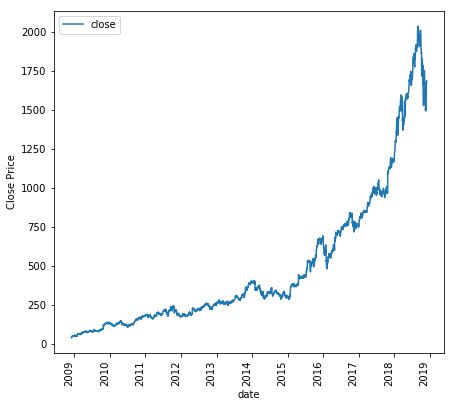

In [26]:
fig, ax = plt.subplots(figsize=(7, 7))
ama.plot(x='date', y='close',rot=90,ax=ax)
ax.set_ylabel('Close Price')

### Q.2 Scale the data using MinMaxScaler (5 pts)

In [27]:
### YOUR CODE HERE ###
scalerama = MinMaxScaler().fit(ama[['close']])
amas=scalerama.transform(ama[['close']])

In [28]:
amas.shape

(2519, 1)

In [29]:
#amas=pd.DataFrame({'date':ama['date'],'close':amas[:,0],'volume':amas[:,1],'open':amas[:,2],'high':amas[:,3],'low':amas[:,4]})
amas=pd.DataFrame({'date':ama['date'],'close':amas[:,0]})

In [30]:
amas=amas[['date','close']]

In [31]:
amas.head()

,date,close
2518,2008-12-01,0.000000
2517,2008-12-02,0.000360
2516,2008-12-03,0.002371
2515,2008-12-04,0.003427
2514,2008-12-05,0.003897


In [32]:
amzn=amas
amzn.head()

,date,close
2518,2008-12-01,0.000000
2517,2008-12-02,0.000360
2516,2008-12-03,0.002371
2515,2008-12-04,0.003427
2514,2008-12-05,0.003897


#### Creates dataset in correct format for RNNs

In [33]:
def create_dataset(dataset, window_size):
    """
    Creates x and y data sets used for training the LSTM model in the format which is acceptable by Keras API
    Parameters:
        data : Stock price history (as numpy array)
        window_size : Number of data points to be used to predict/forecast next data point
    
    Returns:
        x : Feature inputs
        y : Target labels
    """
    data_X, data_Y = [], []
    for i in range(len(dataset) - window_size - 1):
        # Creating sets of data points (close price) to predict for next day
        data_X.append(dataset[i:(i + window_size), 1]) ## 1 - 'close' price from dataframe
        data_Y.append(dataset[i + window_size, 1])
    # Converting list to numpy array
    data_X = np.array(data_X)
    data_Y = np.array(data_Y)
    # Reshaping it according to LSTM input
    x = np.reshape(data_X, (data_X.shape[0], 1, data_X.shape[1]))
    y = np.reshape(data_Y, (data_Y.shape[0], 1, 1))
    return x, y

window_size = 22
x, y = create_dataset(amzn.values, window_size)

### Q.3 Create the model containing LSTM layers (20 pts)
----
Input shape of first 'LSTM' layer : (1, window_size)<br>
Output  of final 'Dense' layer : 1

In [34]:
def lstm_model(x, window_size):
    """
    Creates the model which will be used to forecast next day's stock price based on previous values as inputs
    Parameters:
        x : Feature inputs
        window_size : Number of data points to be used to predict/forecast next data point
    
    Returns:
        model : Model architecture created using Keras
    """
    ### YOUR CODE HERE ###
    model = Sequential()
    model.add(LSTM(500, input_shape=(1,window_size),return_sequences=True))
    model.add(LSTM(window_size, return_sequences=True))
    model.add(Dense(units=500, activation='relu', input_dim=1))
    model.add(Dense(units=1000, activation='relu', input_dim=1))
    model.add(Dense(units=1000, activation='relu', input_dim=1))
    model.add(Dense(units=1000, activation='relu', input_dim=1))
    model.add(Dense(units=500, activation='relu', input_dim=1))
    model.add(Dense(units=1))
    print (model.summary())
    return model

model = lstm_model(x, window_size)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 1, 500)            1046000   
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 22)             46024     
_________________________________________________________________
dense_7 (Dense)              (None, 1, 500)            11500     
_________________________________________________________________
dense_8 (Dense)              (None, 1, 1000)           501000    
_________________________________________________________________
dense_9 (Dense)              (None, 1, 1000)           1001000   
_________________________________________________________________
dense_10 (Dense)             (None, 1, 1000)           1001000   
_________________________________________________________________
dense_11 (Dense)             (None, 1, 500)            500500    
__________

### Q.4 Compile the model by specifying optimizer, loss metrics and train the network by specifying batch_size and epochs (10 pts)

Play around with the hypar-parameters and **discuss** what changes caused the mean-squared error go up or down

In [35]:
model.compile(optimizer='adam',
            loss='mean_squared_error',
            metrics = ['mse'])
model.fit(x=x, y=y, batch_size=8, epochs=50)

Epoch 1/50
2496/2496 [==============================] - 40s 16ms/step - loss: 0.0037 - mean_squared_error: 0.0037
Epoch 2/50
2496/2496 [==============================] - 43s 17ms/step - loss: 7.1498e-04 - mean_squared_error: 7.1498e-04
Epoch 3/50
2496/2496 [==============================] - 39s 16ms/step - loss: 8.8677e-04 - mean_squared_error: 8.8677e-04
Epoch 4/50
2496/2496 [==============================] - 42s 17ms/step - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 5/50
2496/2496 [==============================] - 35s 14ms/step - loss: 7.0235e-04 - mean_squared_error: 7.0235e-04
Epoch 6/50
2496/2496 [==============================] - 32s 13ms/step - loss: 5.2377e-04 - mean_squared_error: 5.2377e-04
Epoch 7/50
2496/2496 [==============================] - 34s 14ms/step - loss: 7.1744e-04 - mean_squared_error: 7.1744e-04
Epoch 8/50
2496/2496 [==============================] - 32s 13ms/step - loss: 3.9945e-04 - mean_squared_error: 3.9945e-04
Epoch 9/50
2496/2496 [==================

In [40]:
from sklearn.metrics import mean_squared_error
print("The MSE is %f" % mean_squared_error(amzn.loc[23:,'close'],amzn.loc[23:,'Predictions']))

The MSE is 628.382496


(Your answer here)
Increasing the number of epochs and decreasing the batch size caused the mean square error to go down

### Q.5 Get the predictions and visualize the results (5 pts)
Helper functions will do the needful, you just need to make sure the model is trained and data is consistent

In [36]:
def predict(amzn1, x, window_size, batch_size=8):
    """
    Uses trained model to predict on the input set, scales data back to original distribution
    and returns the original dataframe with an added column containing predictions
    
    Parameters:
        amzn : Original dataframe of Amazon stock prices
        x : Feature inputs used to train the model
        batch_size : Batch_size used for training the model
    
    Returns:
        amzn : Amazon stock price dataframe with an added column containing predictions made by the trained model
    """
    preds = []
    amzn1.reset_index(drop=True, inplace=True)
    # Iterating over training samples
    for i in range(len(x)):
        data = np.reshape(x[i], (1, 1, 22))
        # Predicting from the trained model
        preds.append(model.predict(x=data, batch_size=batch_size)[0][0][0])
    predictions = np.copy(scalerama.inverse_transform(np.array(preds).reshape(-1, 1)))
    amzn1.loc[window_size+1:,'Predictions'] = np.copy(predictions)
    amzn1.loc[:,'close'] = np.copy(scalerama.inverse_transform(amzn.loc[:,'close'].values.reshape(-1, 1)))
    return amzn1

amzn=predict(amzn, x, window_size)

In [37]:
amzn.head(50)

,date,close,Predictions
0,2008-12-01,40.470,NaN
1,2008-12-02,41.190,NaN
2,2008-12-03,45.210,NaN
3,2008-12-04,47.320,NaN
4,2008-12-05,48.260,NaN
5,2008-12-08,51.410,NaN
6,2008-12-09,51.250,NaN
7,2008-12-10,49.700,NaN
8,2008-12-11,48.250,NaN
9,2008-12-12,51.250,NaN


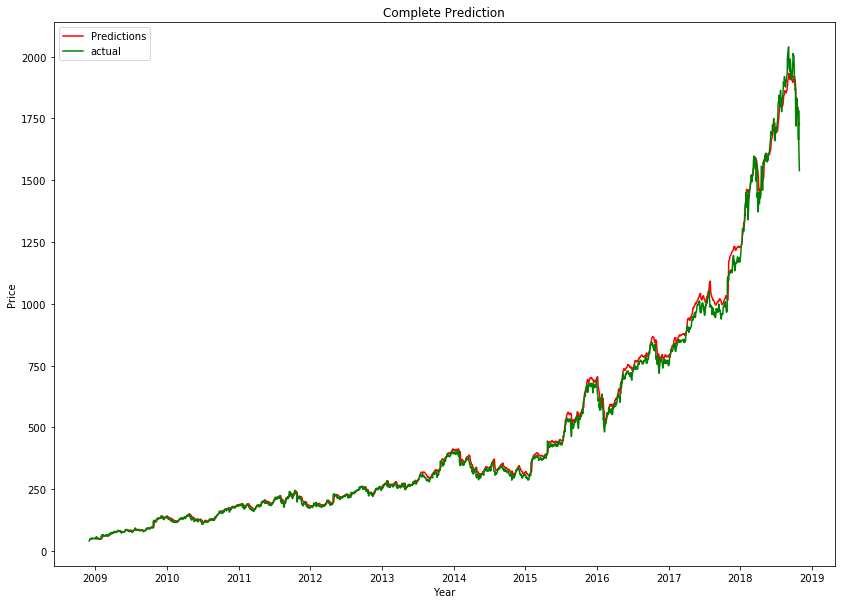

In [38]:
def plot_predictions(amzn, title, idx1=0, idx2=len(x)):
    """
    Plots the predictions on top of original stock price history
    
    Parameters:
        amzn : Original dataframe of Amazon stock prices
        title : Title of the plot
    
    Returns:
        amzn : Amazon stock price dataframe with an added column containing predictions made by the trained model
    """
    plt.figure(figsize=(14, 10))
    plt.plot(amzn.date[idx1:idx2], amzn.Predictions[idx1:idx2], label='Predictions', color='red')
    plt.plot(amzn.date[idx1:idx2], amzn.close[idx1:idx2], label='actual', color='green')
    plt.xlabel("Year")
    plt.ylabel("Price")
    plt.title(title)
    plt.legend()
    plt.show()
    
# The plot should look something like this    
title = "Complete Prediction"
plot_predictions(amzn, title)

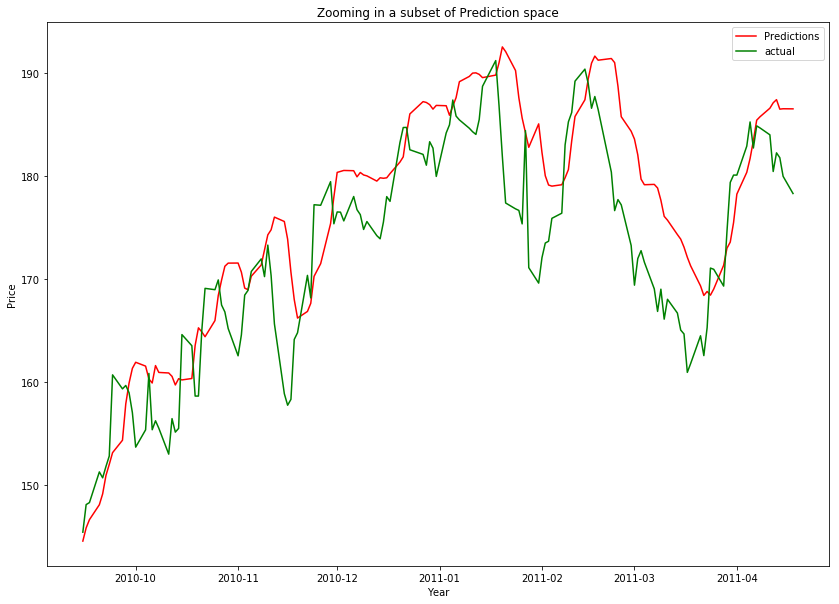

In [39]:
# Same function can be used to zoom in on a particular sub-space of predictions
title = "Zooming in a subset of Prediction space"
plot_predictions(amzn, title, 450, 600)